# Summary 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
from skfeature.function.information_theoretical_based.MRMR import mrmr
from skfeature.function.information_theoretical_based.MIM import mim
from art.attacks.evasion import FastGradientMethod, DeepFool
from art.estimators.classification import SklearnClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import mutual_info_classif
from art.utils import to_categorical
from sklearn.manifold import TSNE
import xlwt
from xlwt import Workbook
import xlsxwriter

plt.style.use('bmh')

# Generate t-SNE Plots 

In [2]:
# get the names of the datasets
# data_sets = [file[:-4] for file in os.listdir('data/')]

data_sets = ['breast-cancer-wisc-diag',
             'breast-cancer-wisc-prog',
             'conn-bench-sonar-mines-rocks',
             'cylinder-bands',
             'ionosphere',
             'molec-biol-promoter',
             'musk-1',
             'oocytes_merluccius_nucleus_4d',
             'oocytes_trisopterus_nucleus_2f',
             'parkinsons',
             'spectf_train'
            ]

data_sets

['breast-cancer-wisc-diag',
 'breast-cancer-wisc-prog',
 'conn-bench-sonar-mines-rocks',
 'cylinder-bands',
 'ionosphere',
 'molec-biol-promoter',
 'musk-1',
 'oocytes_merluccius_nucleus_4d',
 'oocytes_trisopterus_nucleus_2f',
 'parkinsons',
 'spectf_train']

In [3]:
# generate dataset table
for i in range(len(data_sets)): 
    df = pd.read_csv('data/' + data_sets[i] + '.csv', header=None)
    X, y = df.values[:,:-1], df.values[:,-1]
    ns, nf = X.shape
    cc = 1.*np.max([(y==0).sum(), (y==1).sum()])/len(y)
    s = data_sets[i].replace('-', ' ').replace('_', ' ') + ' & ' + str(ns) + ' & ' + str(nf) + ' & ' + str(np.floor(1000*cc)/10) + '\\\\'
    print(s)

breast cancer wisc diag & 569 & 30 & 62.7\\
breast cancer wisc prog & 198 & 33 & 76.2\\
conn bench sonar mines rocks & 208 & 60 & 53.3\\
cylinder bands & 512 & 35 & 60.9\\
ionosphere & 351 & 33 & 64.1\\
molec biol promoter & 106 & 57 & 50.0\\
musk 1 & 476 & 166 & 56.5\\
oocytes merluccius nucleus 4d & 1022 & 41 & 67.0\\
oocytes trisopterus nucleus 2f & 912 & 25 & 57.7\\
parkinsons & 195 & 22 & 75.3\\
spectf train & 80 & 44 & 50.0\\


breast-cancer-wisc-diag
  > Benign: 455
  > Adversarial: 91
breast-cancer-wisc-prog
  > Benign: 158
  > Adversarial: 31
conn-bench-sonar-mines-rocks
  > Benign: 166
  > Adversarial: 33
cylinder-bands
  > Benign: 409
  > Adversarial: 81
ionosphere
  > Benign: 280
  > Adversarial: 56
molec-biol-promoter
  > Benign: 84
  > Adversarial: 16
musk-1
  > Benign: 380
  > Adversarial: 76
oocytes_merluccius_nucleus_4d
  > Benign: 817
  > Adversarial: 163
oocytes_trisopterus_nucleus_2f
  > Benign: 729
  > Adversarial: 145
parkinsons
  > Benign: 156
  > Adversarial: 31
spectf_train
  > Benign: 64
  > Adversarial: 12


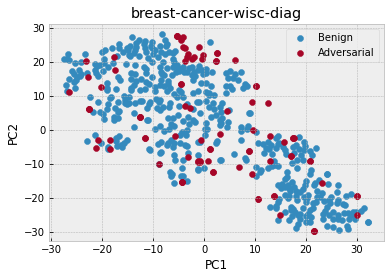

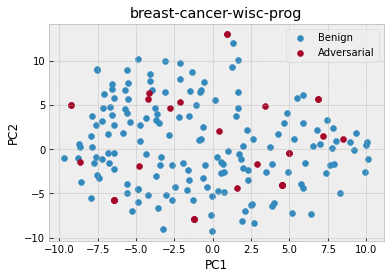

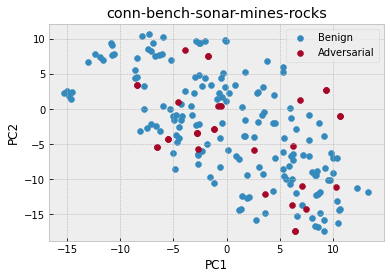

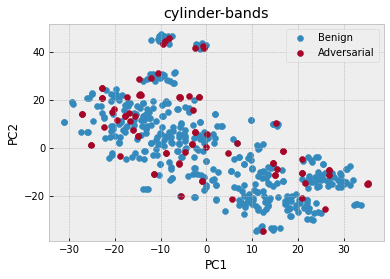

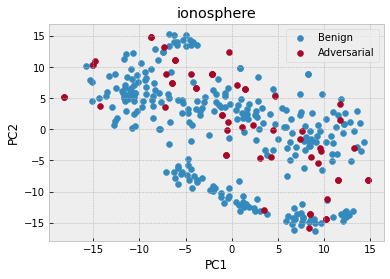

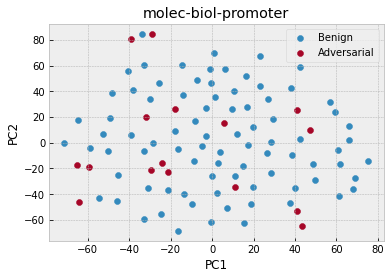

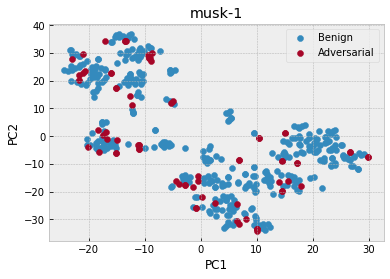

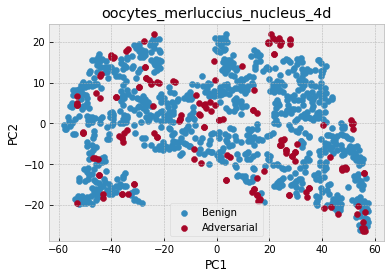

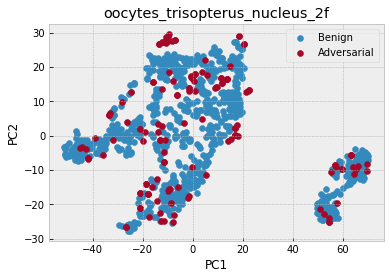

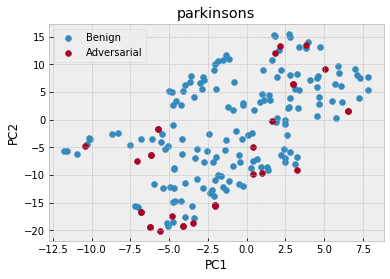

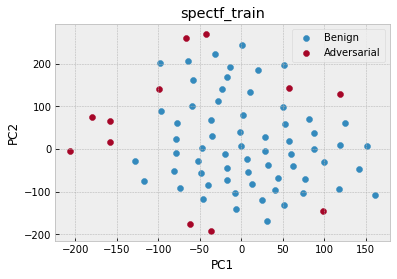

In [4]:
# generate TSNE plots of the normal and adversarial data that were generated with FGSM -- MLP
attack_type = 'fgsm'
for i in range(len(data_sets)): 

    np.random.seed(1)
    D = np.load('outputs/Classifier_NN/fgsm/adversarial_data_' + data_sets[i] + '_' + attack_type + '.npz')
    Xtr, ytr, Xadv, yadv = D['Xtr'], D['ytr'], D['Xadv'], D['yadv']
    
    print(data_sets[i])
    print('  > Benign: ' + str(len(ytr)))
    print('  > Adversarial: ' + str(len(yadv)))

    X = np.concatenate((Xtr, Xadv))
    y = np.zeros((len(X)))
    y[len(ytr):] = 1
    Xe = TSNE(n_components=2).fit_transform(X)

    plt.figure()
    plt.scatter(Xe[y==0, 0], Xe[y==0, 1], label='Benign')
    plt.scatter(Xe[y==1, 0], Xe[y==1, 1], label='Adversarial')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(data_sets[i])
    plt.legend()
    plt.savefig('outputs/Classifier_NN/fgsm/tsne_plots/' + data_sets[i] + '.pdf')


In [5]:
# generate TSNE plots of the normal and adversarial data that were generated with DeepFool -- MLP

attack_type, clfr = 'embedding', 'nn'

R = np.load('outputs/Embedding/experiment_' + attack_type + '_' + clfr + '.npz')
attack_scores = R['MLP_attack_scores']
    
print(attack_scores)


[[0.44758024 0.81898545]
 [0.69240772 0.57640315]
 [0.62784534 0.6609985 ]
 [0.58498566 0.70631403]
 [0.54557811 0.78346721]
 [0.63854725 0.62021009]
 [0.56592226 0.74895427]
 [0.53190224 0.76125202]
 [0.58200295 0.7069647 ]
 [0.61738813 0.66153846]
 [0.68836129 0.5375    ]]


# Plot the Mutual Information and mRMR scores 

In [ ]:
# MIM
RUNS = 5
NBEST = 10

for ell in range(len(data_sets)): 
    if data_sets[ell] == 'statlog-german-credit' or data_sets[ell] == 'ozone':
        pass 
    print(data_sets[ell])

    df = pd.read_csv(''.join(['data/', data_sets[ell], '.csv']), header=None)
    X, y = df.values[:,:-1], df.values[:,-1]
    
    i_perm = np.random.permutation(len(y))
    X, y = X[i_perm], y[i_perm]
    ns = len(y)
    
    ns = int(np.floor(0.8*ns))
    X1, y1, X2, y2 = X[:ns], y[:ns], X[ns:], y[ns:]

    scores_norm, scores_adv = np.zeros((X.shape[1],)), np.zeros((X.shape[1],))

    for k in range(RUNS): 
        idx = np.random.randint(0, len(y1), len(y1))
        #_, _, mi_score = mim(X1[idx], y1[idx])
        #scores_norm += mi_score[:-1]
        mi_score = mutual_info_classif(X1[idx], y1[idx])
        scores_norm += mi_score
    
        y1_ohe = tf.keras.utils.to_categorical(y1, 2)
        clfr = SVC(C=1.0, kernel='rbf')
        clfr = SklearnClassifier(clfr, clip_values=(-5.,5.))
        clfr.fit(X1, y1_ohe)
    
        attack = FastGradientMethod(estimator=clfr, eps=.2)
        Xadv = attack.generate(x=X2)
        yadv = y2
    
        Xa, ya = np.concatenate((X1[idx], Xadv)), np.concatenate((y1[idx], yadv))
    
        #_, _, mi_score = mim(Xa, ya)
        #scores_adv += mi_score[:-1]
        mi_score = mutual_info_classif(Xa, ya)
        scores_adv += mi_score
    
    
    scores_norm /= RUNS
    scores_adv /= RUNS
    i_sorted = np.argsort(scores_norm)[::-1]

    i_sorted = i_sorted[:NBEST]
    scores_adv = scores_adv[i_sorted]
    scores_norm = scores_norm[i_sorted]

    x = [i for i in range(len(i_sorted))]

    # create plot
    n_groups = len(x)
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 1.

    rects1 = plt.bar(index, scores_norm, bar_width, alpha=opacity, label='Benign')
    rects2 = plt.bar(index+bar_width, scores_adv, bar_width, alpha=opacity, label='Adversarial')
    plt.xlabel('Feature Rank')
    plt.ylabel('Mutual Information')
    plt.legend()
    plt.tight_layout()
    plt.savefig(''.join(['outputs/barchar_mi_', data_sets[ell],'.pdf']))

In [ ]:
# mRMR
RUNS = 5
NBEST = 10

for ell in range(len(data_sets)): 
    if data_sets[ell] == 'statlog-german-credit' or data_sets[ell] == 'ozone':
        pass 
    print(data_sets[ell])

    df = pd.read_csv(''.join(['data/', data_sets[ell], '.csv']), header=None)
    X, y = df.values[:,:-1], df.values[:,-1]
    
    i_perm = np.random.permutation(len(y))
    X, y = X[i_perm], y[i_perm]
    ns = len(y)
    
    ns = int(np.floor(0.8*ns))
    X1, y1, X2, y2 = X[:ns], y[:ns], X[ns:], y[ns:]

    scores_norm, scores_adv = np.zeros((X.shape[1],)), np.zeros((X.shape[1],))

    for k in range(RUNS): 
        idx = np.random.randint(0, len(y1), len(y1))
        _, mi_score, _ = mrmr(X1[idx], y1[idx], n_selected_features=X.shape[1])
        scores_norm += mi_score
        
        y1_ohe = tf.keras.utils.to_categorical(y1, 2)
        clfr = SVC(C=1.0, kernel='rbf')
        clfr = SklearnClassifier(clfr, clip_values=(-5.,5.))
        clfr.fit(X1, y1_ohe)
    
        attack = FastGradientMethod(estimator=clfr, eps=.2)
        Xadv = attack.generate(x=X2)
        yadv = y2
    
        Xa, ya = np.concatenate((X1[idx], Xadv)), np.concatenate((y1[idx], yadv))
    
        _, mi_score, _ = mrmr(Xa, ya, n_selected_features=X.shape[1])
        scores_adv += mi_score
    
    
    scores_norm /= RUNS
    scores_adv /= RUNS
    i_sorted = np.argsort(scores_norm)[::-1]

    i_sorted = i_sorted[:NBEST]
    scores_adv = scores_adv[i_sorted]
    scores_norm = scores_norm[i_sorted]

    x = [i for i in range(len(i_sorted))]

    # create plot
    n_groups = len(x)
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.35
    opacity = 1.

    rects1 = plt.bar(index, scores_norm, bar_width, alpha=opacity, label='Benign')
    rects2 = plt.bar(index+bar_width, scores_adv, bar_width, alpha=opacity, label='Adversarial')
    plt.xlabel('Feature Rank')
    plt.ylabel('mRMR Score')
    plt.legend()
    plt.tight_layout()
    plt.savefig(''.join(['outputs/barchar_mrmr_', data_sets[ell],'.pdf']))

# Generate Stability Tables / Figures

In [ ]:
def print_table_scores(rnames, cnames, table): 
    
    s = ' & '
    for c in cnames: 
        s += c + ' & '
    s = s[:-2] + '\\\\'
    print(s)
    
    for i in range(len(rnames)): 
        s = rnames[i].replace('-', ' ').replace('_', ' ')
        for j in range(table.shape[1]): 
            s += ' & ' + str(np.floor(table[i, j]*10000)/100)
        s += ' \\\\'
        print(s)
    

Jaccard distance between benign and adversarial
[[0.96363636 0.93333333 0.85       0.21904762 0.49536738]
 [0.96363636 0.89090909 0.52157287 0.45641026 0.47545788]
 [0.83496503 0.92727273 0.82424242 0.08274854 0.35793651]
 [1.         1.         1.         0.4972396  0.78268398]
 [1.         1.         0.8969697  0.26804266 0.32631976]
 [1.         1.         1.         0.08111455 0.56203404]
 [1.         1.         0.81538462 0.15121136 0.39578755]
 [0.96363636 0.7986014  0.96363636 0.51007326 0.52567041]
 [0.75757576 0.8969697  1.         0.8969697  0.76829837]
 [1.         0.89090909 0.77902098 0.39871795 0.60879121]
 [1.         1.         0.96363636 0.39340659 0.56235431]]



Kuncheva distance between benign and adversarial
[[ 0.97        0.94        0.82       -0.02        0.43      ]
 [ 0.97130435  0.91391304  0.45478261  0.45478261  0.48347826]
 [ 0.88        0.952       0.88       -0.032       0.4       ]
 [ 1.          1.          1.          0.468       0.804     ]
 [ 1.    

<ipython-input-4-63deb02e94ba>:117: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


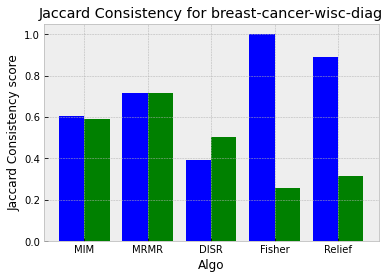

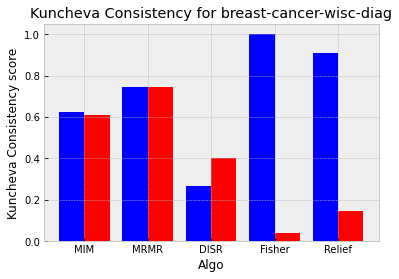

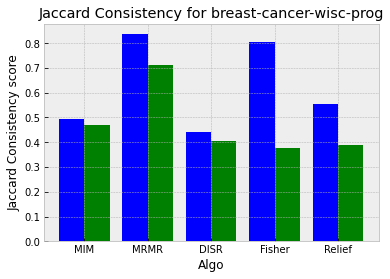

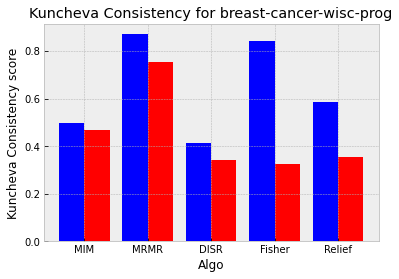

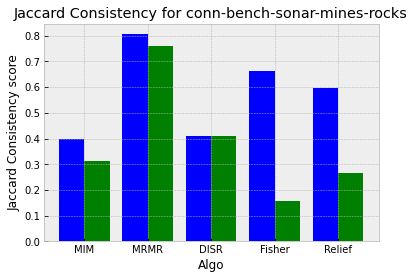

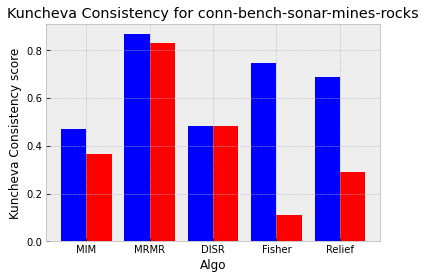

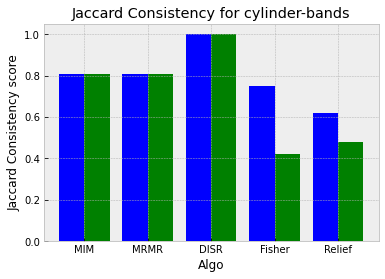

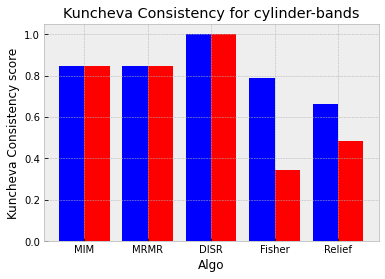

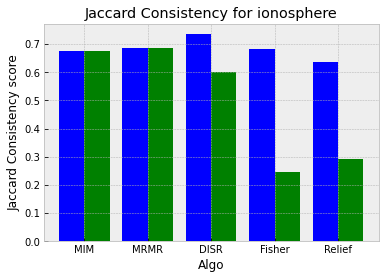

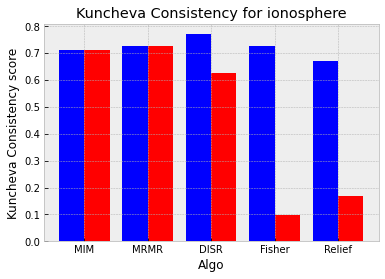

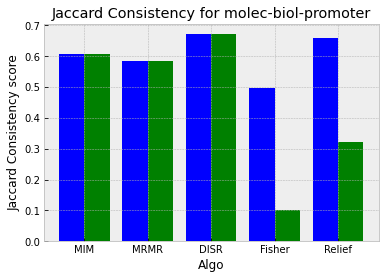

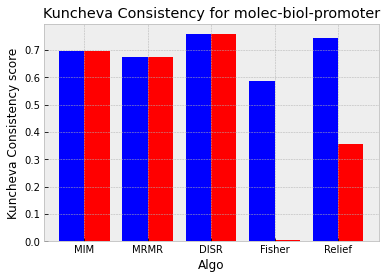

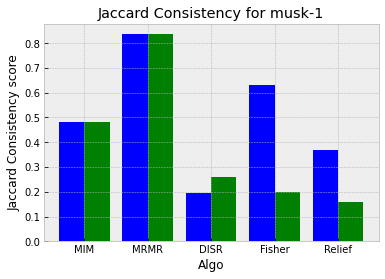

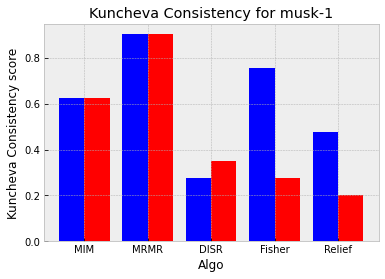

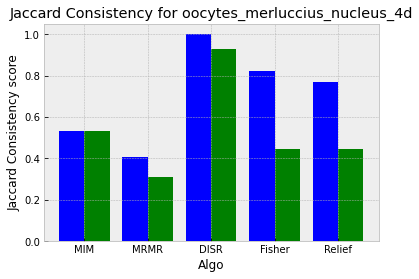

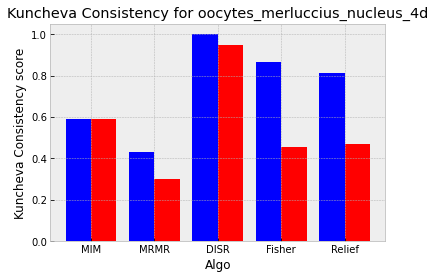

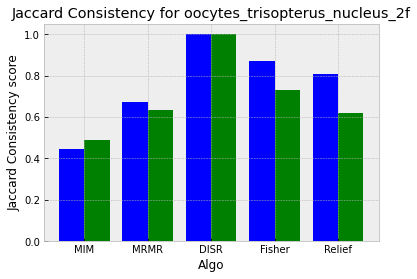

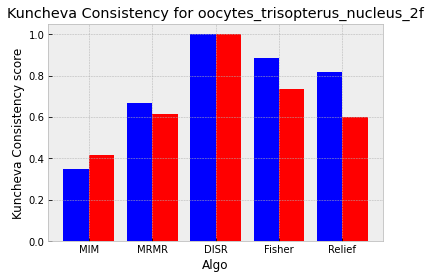

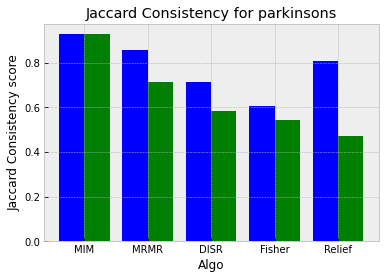

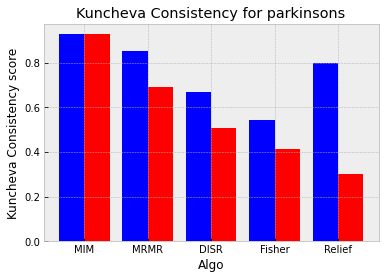

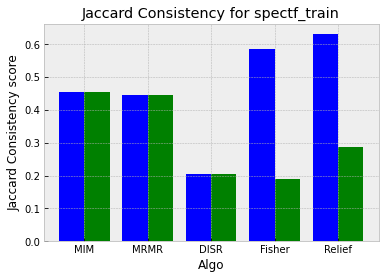

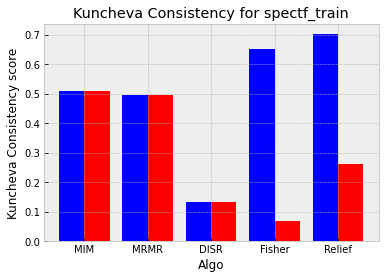

In [4]:
# Generates EXCEL FILE 

attack_type, clfr = 'deepfool', 'lr'

R = np.load('outputs/Classifier_LR/deepfool/experiment_' + attack_type + '_' + clfr + '.npz')

print(R)


fs_jaccard_dist_adv = np.vstack((R['mim_jaccard_dist_adv'], 
                               R['mrmr_jaccard_dist_adv'], 
                               R['disr_jaccard_dist_adv'], 
                               R['fisher_jaccard_dist_adv'], 
                               R['relief_jaccard_dist_adv'])).T


fs_kuncheva_dist_adv = np.vstack((R['mim_kuncheva_dist_adv'], 
                               R['mrmr_kuncheva_dist_adv'], 
                               R['disr_kuncheva_dist_adv'], 
                               R['fisher_kuncheva_dist_adv'], 
                               R['relief_kuncheva_dist_adv'])).T

fs_jaccard_consis_clean = np.vstack((R['mim_jaccard_consistency_clean'], 
                               R['mrmr_jaccard_consistency_clean'], 
                               R['disr_jaccard_consistency_clean'], 
                               R['fisher_jaccard_consistency_clean'], 
                               R['relief_jaccard_consistency_clean'])).T

fs_jaccard_consis_adv = np.vstack((R['mim_jaccard_consistency_adv'], 
                               R['mrmr_jaccard_consistency_adv'], 
                               R['disr_jaccard_consistency_adv'], 
                               R['fisher_jaccard_consistency_adv'], 
                               R['relief_jaccard_consistency_adv'])).T

fs_kuncheva_consis_clean = np.vstack((R['mim_kuncheva_consistency_clean'], 
                               R['mrmr_kuncheva_consistency_clean'], 
                               R['disr_kuncheva_consistency_clean'], 
                               R['fisher_kuncheva_consistency_clean'], 
                               R['relief_kuncheva_consistency_clean'])).T

fs_kuncheva_consis_adv = np.vstack((R['mim_kuncheva_consistency_adv'], 
                               R['mrmr_kuncheva_consistency_adv'], 
                               R['disr_kuncheva_consistency_adv'], 
                               R['fisher_kuncheva_consistency_adv'], 
                               R['relief_kuncheva_consistency_adv'])).T

wb = Workbook()
sheet1 = wb.add_sheet('Jaccard Dist')
for i in range(len(data_sets)):
    for j in range(5):
        sheet1.write(i, j, fs_jaccard_dist_adv[i,j]*100)

sheet2 = wb.add_sheet('Kuncheva Dist')
for i in range(len(data_sets)):
    for j in range(5):
        sheet2.write(i, j, fs_kuncheva_dist_adv[i,j]*100)
        
sheet3 = wb.add_sheet('Jaccard_Consis_BENIGN')
for i in range(len(data_sets)):
    for j in range(5):
        sheet3.write(i, j, fs_jaccard_consis_clean[i,j]*100)
        
sheet4 = wb.add_sheet('Jaccard_Consis_ADVERSARIAL')
for i in range(len(data_sets)):
    for j in range(5):
        sheet4.write(i, j, fs_jaccard_consis_adv[i,j]*100)
    
sheet5 = wb.add_sheet('Kuncheva_Consis_BENIGN')
for i in range(len(data_sets)):
    for j in range(5):
        sheet5.write(i, j, fs_kuncheva_consis_clean[i,j]*100)
        
sheet6 = wb.add_sheet('Kuncheva_Consist_ADVERSARIAL')
for i in range(len(data_sets)):
    for j in range(5):
        sheet6.write(i, j, fs_kuncheva_consis_adv[i,j]*100)
        
wb.save('deepfool_lr.xls')

rnames, cnames = R['DATANAMES'], ['MIM', 'mRMR', 'DISR', 'Fisher', 'ReliefF']


print('Jaccard distance between benign and adversarial')
#print_table_scores(rnames, cnames, fs_jaccard_dist_adv)
print(fs_jaccard_dist_adv)
print('\n\n')


print('Kuncheva distance between benign and adversarial')
#print_table_scores(rnames, cnames, fs_kuncheva_dist_adv)
print(fs_kuncheva_dist_adv)
print('\n\n')

print('Jaccard Consistentency on benign data')
print(fs_jaccard_consis_clean*100)
#print_table_scores(rnames, cnames, fs_jaccard_consis)
print('\n\n')

print('# Jaccard Consistentency on adversarial data')
print(fs_jaccard_consis_adv*100)
#print_table_scores(rnames, cnames, fs_jaccard_consis)
print('\n\n')

print('Kuncheva Consistentency on benign data')
print(fs_kuncheva_consis_clean*100)
#print_table_scores(rnames, cnames, fs_kuncheva_consis)
print('\n\n')

print('# Kuncheva Consistentency on adversarial data')
print(fs_kuncheva_consis_adv*100)
#print_table_scores(rnames, cnames, fs_kuncheva_consis)
print('\n\n')

algo = ['MIM', 'MRMR', 'DISR', 'Fisher', 'Relief']
X_axis = np.arange(len(algo))
for i in range(len(data_sets)):
    plt.figure()
    for j in range(len(algo)):
        
        plt.bar(j - 0.2, fs_jaccard_consis_clean[i][j], color = 'b', width = 0.4) #, label = 'Clean')
        plt.bar(j + 0.2, fs_jaccard_consis_adv[i][j], color = 'g', width = 0.4) #, label = 'Adversarial')
    
    
    plt.xticks(X_axis, algo)
    plt.xlabel("Algo")
    plt.ylabel("Jaccard Consistency score")
    plt.title('Jaccard Consistency for '+ data_sets[i])
    
    

    plt.figure()
    for j in range(len(algo)):
        
        plt.bar(j - 0.2, fs_kuncheva_consis_clean[i][j], color = 'b', width = 0.4) #, label = 'Clean')
        plt.bar(j + 0.2, fs_kuncheva_consis_adv[i][j], color = 'r', width = 0.4) #, label = 'Adversarial')
    
    
    plt.xticks(X_axis, algo)
    plt.xlabel("Algo")
    plt.ylabel("Kuncheva Consistency score")
    plt.title('Kuncheva Consistency for '+ data_sets[i])
    

In [2]:
# DONT DELETE IT, PATTERN ATTACK  poisoning percentage = 80%, yadv = np.random.randint(0, 2, len(yy)), target label --> yte[0,1]

attack_type, clfr = 'svc', 'svc'

R = np.load('outputs/Classifier_SVC/SupportVectorAttacks/experiment_' + attack_type + '_' + clfr + '.npz')

print(R)


fs_jaccard_dist_adv = np.vstack((R['mim_jaccard_scores'], 
                               R['mrmr_jaccard_scores'], 
                               R['disr_jaccard_scores'], 
                               R['fisher_jaccard_scores'], 
                               R['relief_jaccard_scores'])).T


fs_kuncheva_dist_adv = np.vstack((R['mim_kuncheva_scores'], 
                               R['mrmr_kuncheva_scores'], 
                               R['disr_kuncheva_scores'], 
                               R['fisher_kuncheva_scores'], 
                               R['relief_kuncheva_scores'])).T

fs_jaccard_consis_clean = np.vstack((R['mim_jaccard_consistency'], 
                               R['mrmr_jaccard_consistency'], 
                               R['disr_jaccard_consistency'], 
                               R['fisher_jaccard_consistency'], 
                               R['relief_jaccard_consistency'])).T

# fs_jaccard_consis_adv = np.vstack((R['mim_jaccard_consistency_adv'], 
#                                R['mrmr_jaccard_consistency_adv'], 
#                                R['disr_jaccard_consistency_adv'], 
#                                R['fisher_jaccard_consistency_adv'], 
#                                R['relief_jaccard_consistency_adv'])).T

fs_kuncheva_consis_clean = np.vstack((R['mim_kuncheva_consistency'], 
                               R['mrmr_kuncheva_consistency'], 
                               R['disr_kuncheva_consistency'], 
                               R['fisher_kuncheva_consistency'], 
                               R['relief_kuncheva_consistency'])).T

# fs_kuncheva_consis_adv = np.vstack((R['mim_kuncheva_consistency_adv'], 
#                                R['mrmr_kuncheva_consistency_adv'], 
#                                R['disr_kuncheva_consistency_adv'], 
#                                R['fisher_kuncheva_consistency_adv'], 
#                                R['relief_kuncheva_consistency_adv'])).T




rnames, cnames = R['DATANAMES'], ['MIM', 'mRMR', 'DISR', 'Fisher', 'ReliefF']


print('SVM Attack: Jaccard distance between benign and adversarial')
#print_table_scores(rnames, cnames, fs_jaccard_dist_adv)
print(fs_jaccard_dist_adv)
print('\n\n')


print('SVM Attack: Kuncheva distance between benign and adversarial')
#print_table_scores(rnames, cnames, fs_kuncheva_dist_adv)
print(fs_kuncheva_dist_adv)
print('\n\n')

print('SVM Attack: Jaccard Consistentency on benign data')
print(fs_jaccard_consis_clean*100)
#print_table_scores(rnames, cnames, fs_jaccard_consis)
print('\n\n')

# print('# Jaccard Consistentency on adversarial data')
# print(fs_jaccard_consis_adv*100)
# #print_table_scores(rnames, cnames, fs_jaccard_consis)
# print('\n\n')

print('# SVM Attack: Kuncheva Consistentency on benign data')
print(fs_kuncheva_consis_clean*100)
#print_table_scores(rnames, cnames, fs_kuncheva_consis)
print('\n\n')

# print('# Kuncheva Consistentency on adversarial data')
# print(fs_kuncheva_consis_adv*100)
# #print_table_scores(rnames, cnames, fs_kuncheva_consis)
# print('\n\n')

# algo = ['MIM', 'MRMR', 'DISR', 'Fisher', 'Relief']
# X_axis = np.arange(len(algo))
# for i in range(len(data_sets)):
#     plt.figure()
#     for j in range(len(algo)):
        
#         plt.bar(j - 0.2, fs_jaccard_consis_clean[i][j], color = 'b', width = 0.4) #, label = 'Clean')
#         plt.bar(j + 0.2, fs_jaccard_consis_adv[i][j], color = 'g', width = 0.4) #, label = 'Adversarial')
    
    
#     plt.xticks(X_axis, algo)
#     plt.xlabel("Algo")
#     plt.ylabel("Jaccard Consistency score")
#     plt.title('Jaccard Consistency for '+ data_sets[i])
    
    

#     plt.figure()
#     for j in range(len(algo)):
        
#         plt.bar(j - 0.2, fs_kuncheva_consis_clean[i][j], color = 'b', width = 0.4) #, label = 'Clean')
#         plt.bar(j + 0.2, fs_kuncheva_consis_adv[i][j], color = 'r', width = 0.4) #, label = 'Adversarial')
    
    
#     plt.xticks(X_axis, algo)
#     plt.xlabel("Algo")
#     plt.ylabel("Kuncheva Consistency score")
#     plt.title('Kuncheva Consistency for '+ data_sets[i])
    

NameError: name 'np' is not defined

In [3]:
# MLP PATTERN 'rand_yte'

attack_type, clfr = 'fgsm', 'nn'

R = np.load('outputs/Classifier_NN/fgsm/experiment_' + attack_type + '_' + clfr + '.npz')

print(R)


fs_jaccard_dist_adv = np.vstack((R['mim_jaccard_dist_adv'], 
                               R['mrmr_jaccard_dist_adv'], 
                               R['disr_jaccard_dist_adv'], 
                               R['fisher_jaccard_dist_adv'], 
                               R['relief_jaccard_dist_adv'])).T


fs_kuncheva_dist_adv = np.vstack((R['mim_kuncheva_dist_adv'], 
                               R['mrmr_kuncheva_dist_adv'], 
                               R['disr_kuncheva_dist_adv'], 
                               R['fisher_kuncheva_dist_adv'], 
                               R['relief_kuncheva_dist_adv'])).T

fs_jaccard_consis_clean = np.vstack((R['mim_jaccard_consistency_clean'], 
                               R['mrmr_jaccard_consistency_clean'], 
                               R['disr_jaccard_consistency_clean'], 
                               R['fisher_jaccard_consistency_clean'], 
                               R['relief_jaccard_consistency_clean'])).T

fs_jaccard_consis_adv = np.vstack((R['mim_jaccard_consistency_adv'], 
                               R['mrmr_jaccard_consistency_adv'], 
                               R['disr_jaccard_consistency_adv'], 
                               R['fisher_jaccard_consistency_adv'], 
                               R['relief_jaccard_consistency_adv'])).T

fs_kuncheva_consis_clean = np.vstack((R['mim_kuncheva_consistency_clean'], 
                               R['mrmr_kuncheva_consistency_clean'], 
                               R['disr_kuncheva_consistency_clean'], 
                               R['fisher_kuncheva_consistency_clean'], 
                               R['relief_kuncheva_consistency_clean'])).T

fs_kuncheva_consis_adv = np.vstack((R['mim_kuncheva_consistency_adv'], 
                               R['mrmr_kuncheva_consistency_adv'], 
                               R['disr_kuncheva_consistency_adv'], 
                               R['fisher_kuncheva_consistency_adv'], 
                               R['relief_kuncheva_consistency_adv'])).T

wb = Workbook()
sheet1 = wb.add_sheet('Jaccard Dist')
for i in range(len(data_sets)):
    for j in range(5):
        sheet1.write(i, j, fs_jaccard_dist_adv[i,j])

sheet2 = wb.add_sheet('Kuncheva Dist')
for i in range(len(data_sets)):
    for j in range(5):
        sheet2.write(i, j, fs_kuncheva_dist_adv[i,j])
        
sheet3 = wb.add_sheet('Jaccard_Consis_BENIGN')
for i in range(len(data_sets)):
    for j in range(5):
        sheet3.write(i, j, fs_jaccard_consis_clean[i,j]*100)
        
sheet4 = wb.add_sheet('Jaccard_Consis_ADVERSARIAL')
for i in range(len(data_sets)):
    for j in range(5):
        sheet4.write(i, j, fs_jaccard_consis_adv[i,j]*100)
    
sheet5 = wb.add_sheet('Kuncheva_Consis_BENIGN')
for i in range(len(data_sets)):
    for j in range(5):
        sheet5.write(i, j, fs_kuncheva_consis_clean[i,j]*100)
        
sheet6 = wb.add_sheet('Kuncheva_Consist_ADVERSARIAL')
for i in range(len(data_sets)):
    for j in range(5):
        sheet6.write(i, j, fs_kuncheva_consis_adv[i,j]*100)
        
wb.save('nn_fgsm.xls')

rnames, cnames = R['DATANAMES'], ['MIM', 'mRMR', 'DISR', 'Fisher', 'ReliefF']


print('Jaccard distance between benign and adversarial')
#print_table_scores(rnames, cnames, fs_jaccard_dist_adv)
print(fs_jaccard_dist_adv)
print('\n\n')


print('Kuncheva distance between benign and adversarial')
#print_table_scores(rnames, cnames, fs_kuncheva_dist_adv)
print(fs_kuncheva_dist_adv)
print('\n\n')

print('Jaccard Consistentency on benign data')
print(fs_jaccard_consis_clean*100)
#print_table_scores(rnames, cnames, fs_jaccard_consis)
print('\n\n')

print('# Jaccard Consistentency on adversarial data')
print(fs_jaccard_consis_adv*100)
#print_table_scores(rnames, cnames, fs_jaccard_consis)
print('\n\n')

print('Kuncheva Consistentency on benign data')
print(fs_kuncheva_consis_clean*100)
#print_table_scores(rnames, cnames, fs_kuncheva_consis)
print('\n\n')

print('# Kuncheva Consistentency on adversarial data')
print(fs_kuncheva_consis_adv*100)
#print_table_scores(rnames, cnames, fs_kuncheva_consis)
print('\n\n')

algo = ['MIM', 'MRMR', 'DISR', 'Fisher', 'Relief']
X_axis = np.arange(len(algo))
for i in range(len(data_sets)):
    plt.figure()
    for j in range(len(algo)):
        
        plt.bar(j - 0.2, fs_jaccard_consis_clean[i][j], color = 'b', width = 0.4) #, label = 'Clean')
        plt.bar(j + 0.2, fs_jaccard_consis_adv[i][j], color = 'g', width = 0.4) #, label = 'Adversarial')
    
    
    plt.xticks(X_axis, algo)
    plt.xlabel("Algo")
    plt.ylabel("Jaccard Consistency score")
    plt.title('Jaccard Consistency for '+ data_sets[i])
    
    

    plt.figure()
    for j in range(len(algo)):
        
        plt.bar(j - 0.2, fs_kuncheva_consis_clean[i][j], color = 'b', width = 0.4) #, label = 'Clean')
        plt.bar(j + 0.2, fs_kuncheva_consis_adv[i][j], color = 'r', width = 0.4) #, label = 'Adversarial')
    
    
    plt.xticks(X_axis, algo)
    plt.xlabel("Algo")
    plt.ylabel("Kuncheva Consistency score")
    plt.title('Kuncheva Consistency for '+ data_sets[i])
    

NameError: name 'np' is not defined

# Visualize consistency

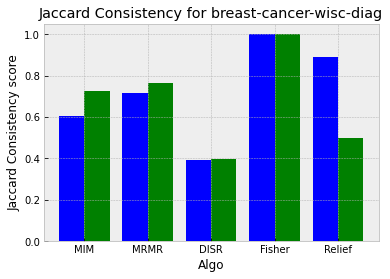

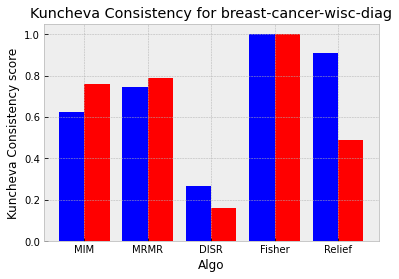

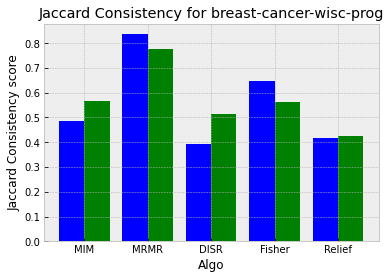

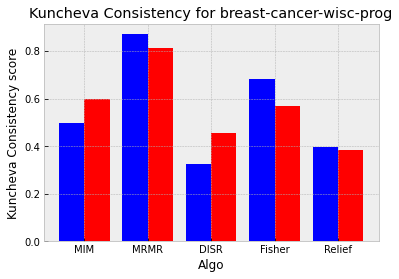

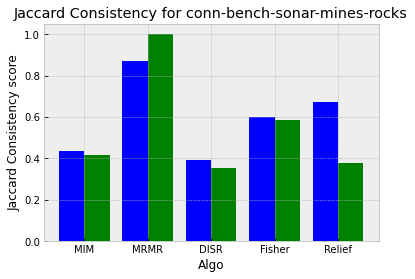

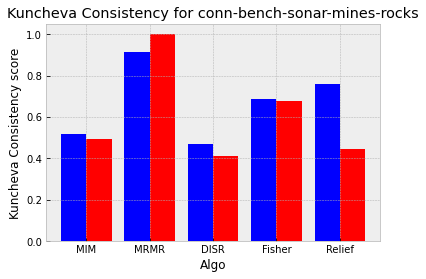

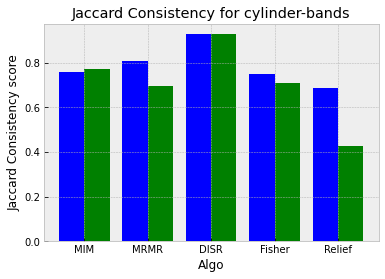

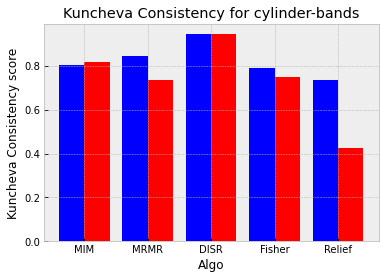

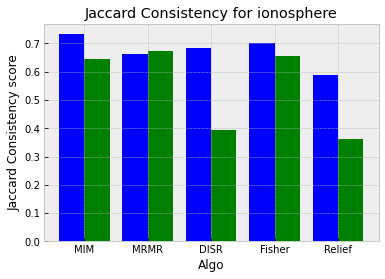

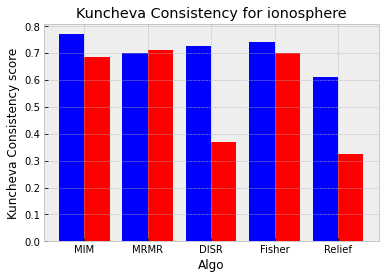

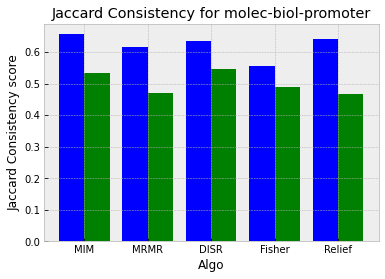

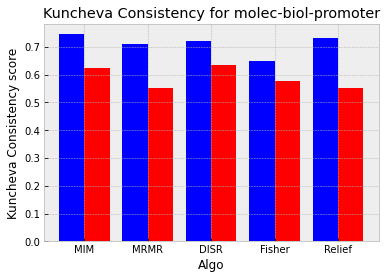

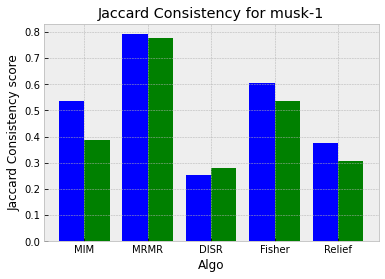

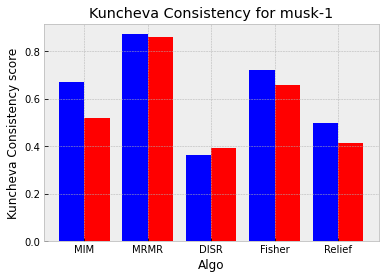

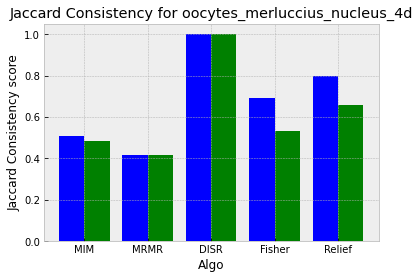

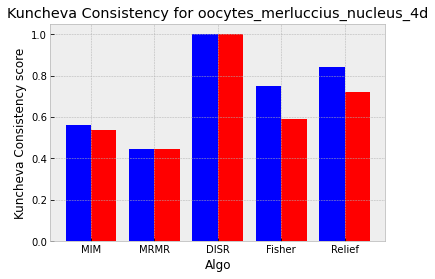

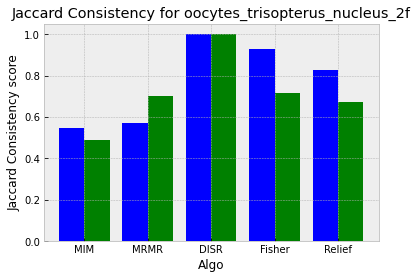

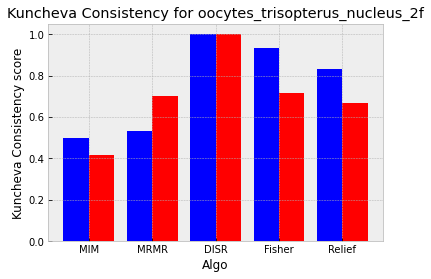

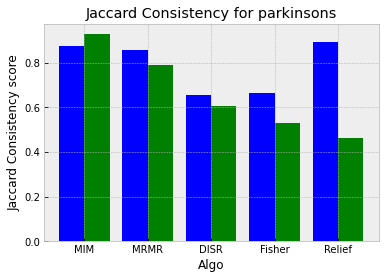

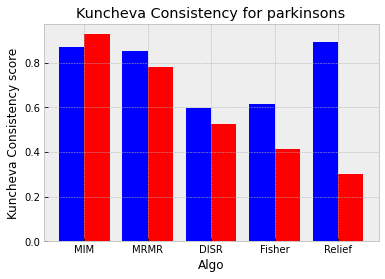

In [33]:
algo = ['MIM', 'MRMR', 'DISR', 'Fisher', 'Relief']
X_axis = np.arange(len(algo))
for i in range(len(data_sets)):
    plt.figure()
    for j in range(len(algo)):
        
        plt.bar(j - 0.2, fs_jaccard_consis_clean[i][j], color = 'b', width = 0.4) #, label = 'Clean')
        plt.bar(j + 0.2, fs_jaccard_consis_adv[i][j], color = 'g', width = 0.4) #, label = 'Adversarial')
    
    
    plt.xticks(X_axis, algo)
    plt.xlabel("Algo")
    plt.ylabel("Jaccard Consistency score")
    plt.title('Jaccard Consistency for '+ data_sets[i])
    
    

    plt.figure()
    for j in range(len(algo)):
        
        plt.bar(j - 0.2, fs_kuncheva_consis_clean[i][j], color = 'b', width = 0.4) #, label = 'Clean')
        plt.bar(j + 0.2, fs_kuncheva_consis_adv[i][j], color = 'r', width = 0.4) #, label = 'Adversarial')
    
    
    plt.xticks(X_axis, algo)
    plt.xlabel("Algo")
    plt.ylabel("Kuncheva Consistency score")
    plt.title('Kuncheva Consistency for '+ data_sets[i])
    

# Check the Correctness of Skfeature

In [ ]:
df = pd.read_csv(''.join(['data/', data_sets[1], '.csv']), header=None)
X, y = df.values[:,:-1], df.values[:,-1]
i_perm = np.random.permutation(len(y))
X, y = X[i_perm], y[i_perm]
K = 10


rank_skfeature, obj_score, mi_score_skfeature = mim(X1[idx], y1[idx])
mi_score_sklearn = mutual_info_classif(X1[idx], y1[idx])
rank_sklearn = np.argsort(mi_score_sklearn)[::-1]


np.sort(rank_sklearn[:K]), np.sort(rank_skfeature[:K])